In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
!pip install -Uqq fastai

In [4]:
!pip install -Uqq duckduckgo_search

In [5]:
from duckduckgo_search import DDGS

In [6]:
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


In [7]:
urls = search_images('bird photos', max_images=1)
urls[0]


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

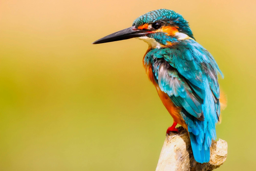

In [8]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

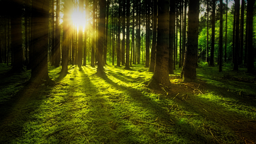

In [9]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)


In [10]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


24

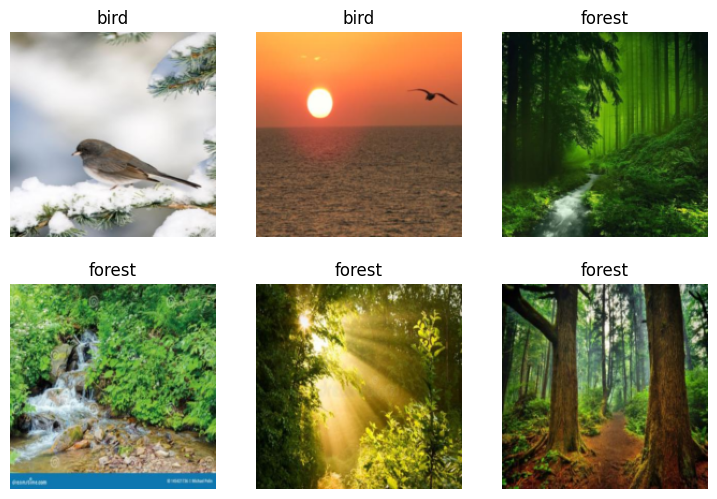

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,0.552846,0.141267,0.033333,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.112522,0.028361,0.005556,00:01
1,0.065775,0.003011,0.000000,00:01
2,0.040257,0.002678,0.000000,00:01


In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}\nProbability it's a forest image: {probs[1]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
Probability it's a forest image: 0.0000
